# ***Importing Necessary libraries***

In [1]:
!pip install tensorflow

import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import tensorflow as tf
import os

from sklearn.preprocessing import MinMaxScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### ***Custom Image Data Generator (To create the batches)***

In [ ]:
def load_img(img_dir, img_list):

    images=[]
    ground_truth_list = []

    for i, image_name in enumerate(img_list):

        if (image_name.split('.')[1] == 'npz'):

            image_file_path = os.path.join(img_dir,image_name)
            
            MRI_image = np.load(image_file_path)

            image = MRI_image['data']

            #image = np.transpose(MRI_image['a'],(1,2,0))          No need to transpose
                      
            #images.append(image[56:184, 56:184])

            images.append(image)

            image_ground_truth = MRI_image['labels'].astype(np.uint8)

            #image_ground_truth = image_ground_truth[56:184, 56:184]

            #n_classes = len(np.unique(image_ground_truth))           not all images have all 10 classes labels so only going to take 10 as total classes

            n_classes = 41

            image_ground_truth = to_categorical(image_ground_truth, num_classes=n_classes)

            ground_truth_list.append(image_ground_truth)

            pass

        pass


    images = np.array(images)
    ground_truth_list = np.array(ground_truth_list)
    
    return(images,ground_truth_list)


def imageLoader(img_dir, img_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X , Y = load_img(img_dir, img_list[batch_start:limit])
            

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
print("Number of GPUs available : ", len(tf.config.list_physical_devices('GPU')))

tf.test.gpu_device_name()

Number of GPUs available :  1


'/device:GPU:0'


(256, 256, 3)

(256, 256)
[[0.20087982 0.1941309  0.18758064 ... 0.84250623 0.8411415  0.8397006 ]
 [0.16866119 0.1688978  0.17190582 ... 0.8434982  0.84376809 0.83810341]
 [0.16795826 0.17171165 0.180415   ... 0.84182854 0.84208423 0.84389152]
 ...
 [0.53594502 0.53864545 0.54885191 ... 0.18115599 0.18070748 0.17958289]
 [0.58295439 0.56841344 0.55833484 ... 0.18166634 0.17977384 0.17806081]
 [0.57463263 0.56380762 0.54394431 ... 0.18409288 0.18383573 0.18914463]]


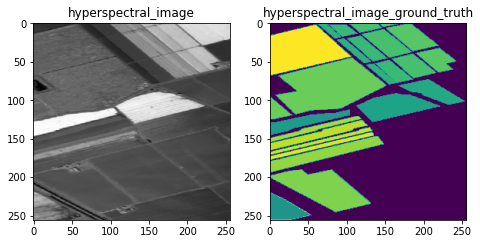

In [ ]:
scaler = MinMaxScaler()


npz_files_folder_path = '/content/drive/MyDrive/pavia_Hyperspectral_images/'

hyperspectral_image_npz = 'salinas31.npz'

image_file_path = os.path.join(npz_files_folder_path, hyperspectral_image_npz)


hyperspectral_image_np_zip = np.load(image_file_path)

hyperspectral_image = hyperspectral_image_np_zip['data']

hyperspectral_image_ground_truth = hyperspectral_image_np_zip['labels'].astype(np.uint8)

#image normalization using MinMax scaler

hyperspectral_image=scaler.fit_transform(hyperspectral_image.reshape(-1, hyperspectral_image.shape[-1])).reshape(hyperspectral_image.shape)


print()

print(hyperspectral_image.shape)

print()

print(hyperspectral_image_ground_truth.shape)


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('hyperspectral_image')
plt.imshow(hyperspectral_image[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('hyperspectral_image_ground_truth')
plt.imshow(hyperspectral_image_ground_truth)

print(hyperspectral_image[:,:,0])


In [ ]:
batch_size = 1

npz_files_folder_path = '/content/drive/MyDrive/pavia_Hyperspectral_images/'

file_name = 'salinas31.npz'

"""file_2 = 'PaviaU_scene_11.npz'

file_3 = 'PaviaU_scene_8.npz'

file_4 = 'PaviaU_scene_9.npz'"""

file_name_list = []

file_name_list.append(file_name)

"""file_name_list.append(file_2)

file_name_list.append(file_3)

file_name_list.append(file_4)"""


train_images_dataGenerator = imageLoader(img_dir=npz_files_folder_path,img_list=file_name_list,batch_size=batch_size)

X, Y = train_images_dataGenerator.__next__()

(1, 256, 256, 3)

(1, 256, 256, 41)


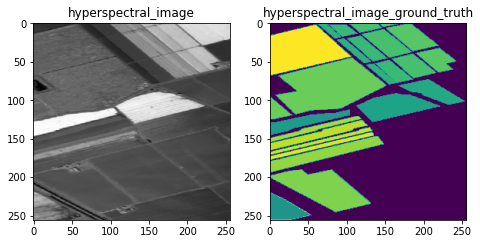

In [ ]:
print(X.shape)
print()

print(Y.shape)


sample_hyperspectral_image = X[0]

sample_ground_truth = Y[0]

#converting to categorical ground truth back to normal ground truth

sample_ground_truth=np.argmax(sample_ground_truth, axis=2)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('hyperspectral_image')
plt.imshow(sample_hyperspectral_image[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('hyperspectral_image_ground_truth')
plt.imshow(sample_ground_truth)



### ***Defining UNET Model***

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from tensorflow.keras.optimizers import Adam

In [ ]:
"""################################################################
def multi_unet_model(n_classes=10, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=103):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    #c1 = Dropout(0.2)(c1)  # Original 0.1
    #c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    #c2 = Dropout(0.2)(c2)  # Original 0.1
    #c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    #c3 = Dropout(0.2)(c3)
    #c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    #c4 = Dropout(0.2)(c4)
    #c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    #c5 = Dropout(0.3)(c5)
    #c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)
    
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    #c6 = Dropout(0.3)(c6)
    #c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    
    
    #Expansive path 
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    #c7 = Dropout(0.2)(c7)
    #c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    #c8 = Dropout(0.2)(c8)
    #c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    #c9 = Dropout(0.2)(c9)  # Original 0.1
    #c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    u10 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
    c10 = Dropout(0.2)(c10)  # Original 0.1
    c10 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
    #c10 = Dropout(0.2)(c10)  # Original 0.1
    #c10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

    u11 = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
    c11 = Dropout(0.2)(c11)  # Original 0.1
    c11 = Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
    #c11 = Dropout(0.2)(c11)  # Original 0.1
    #c11 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c11)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model"""

# ***ATTENTION BLOCK 2nd ORDER POOLING***

In [ ]:

from keras.layers import Layer
import keras.backend as K


class SpatialAttention(Layer):
    def __init__(self,
                 **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=[input_shape[-2], 1],
                                 name='kernel',
                                 initializer='ones',
                                 trainable=True)

        self.bias = self.add_weight(shape=[input_shape[-2]],
                                 name='bias',
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, training=None):

        input_shape = K.int_shape(inputs)
        mid = input_shape[-2] // 2

        coe = K.l2_normalize(K.batch_dot(inputs, K.permute_dimensions(inputs, pattern=(0, 2, 1))), axis=-1)
        coe0 = K.expand_dims(coe[:, mid, :], axis=-1) * self.kernel
        w = K.batch_dot(coe, coe0) + K.expand_dims(self.bias, axis=-1)
        outputs = K.softmax(w, axis=-2) * inputs

        return outputs

    def get_config(self):
        config = {}
        base_config = super(SpatialAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return tuple(input_shape)

In [ ]:

from keras.layers import Layer
import keras.backend as K


class SecondOrderPooling(Layer):
    def __init__(self,
                 **kwargs):
        super(SecondOrderPooling, self).__init__(**kwargs)

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)

        outputs = K.batch_dot(K.permute_dimensions(inputs, pattern=(0, 2, 1)), inputs, axes=[2, 1])
        outputs = K.reshape(outputs, [-1, input_shape[2] * input_shape[2]])

        return outputs

    def get_config(self):
        config = {}
        base_config = super(SecondOrderPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        if len(input_shape) == 4:
            output_shape = list([None, input_shape[1], input_shape[3] * input_shape[3]])
        else:
            output_shape = list([None, input_shape[2] * input_shape[2]])
        return tuple(output_shape)

In [ ]:
from keras.layers import Input
from keras.layers import Flatten, Dense, Reshape,BatchNormalization,Dropout,Lambda
import math
from tensorflow.keras.models import Model
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation
from keras.layers import ZeroPadding2D, ZeroPadding1D
from keras import backend as K

In [ ]:
import numpy
def Symmetry(a, rtol=1e-05):
    return numpy.allclose( a.T, rtol=rtol)

In [ ]:
def aspn(img_rows, img_cols, num_PC, nb_classes):
    CNNInput = Input(shape=(img_rows, img_cols, num_PC), name='i0')
    print(CNNInput.shape)

    conv2d_1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(CNNInput)
    p1 = MaxPooling2D(pool_size=(2, 2))(conv2d_1)
    conv2d_2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)

    F = Reshape([128 * 128, 16])(conv2d_2)
    F = BatchNormalization()(F)
    F = Dropout(rate=0.5)(F)

    F = Lambda(lambda x: K.l2_normalize(x, axis=-1), name='f2')(F)
    F = SpatialAttention(name='f3')(F)
    F = SecondOrderPooling(name='feature1')(F)
    F = Lambda(lambda x: K.l2_normalize(x, axis=-1), name='feature2')(F)
    print(F.shape)
    R1 = Reshape((16,16,1))(F)
    print(R1.shape)
    upsamp_1 = UpSampling2D(size=(2,2))(R1)
    print(upsamp_1.shape)
    upsamp_2 = UpSampling2D(size=(2,2))(upsamp_1)
    print(upsamp_2.shape)
    upsamp_3 = UpSampling2D(size=(2,2))(upsamp_2)
    print(upsamp_3.shape)
    upsamp_4 = UpSampling2D(size=(2,2))(upsamp_3)
    print(upsamp_4.shape)
    #upsamp_1 = ZeroPadding2D(padding=((2,2),(2,2)))(upsamp_3)
    #upsamp_2= ZeroPadding2D(padding=((2,2),(2,2)))(upsamp_1)
    #upsamp_3 = ZeroPadding2D(padding=((2,2),(2,2)))(upsamp_2)
    #upsamp_4= ZeroPadding2D(padding=((2,2),(2,2)))(upsamp_3)
    
    #print(upsamp_1.shape)
    conv = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_4)
    print(conv.shape)
    outputs = Conv2D(nb_classes, (1, 1), activation='softmax')(conv)
     
   #F = Dense(nb_classes, activation='softmax', name='classifier', kernel_initializer ='he_normal')(F)
    
    model = Model(inputs=[CNNInput], outputs=outputs)
    model.summary()
    return model

In [ ]:
model = aspn(img_rows=256, img_cols=256, num_PC=150, nb_classes=41)

(None, 256, 256, 150)
(None, 256)
(None, 16, 16, 1)
(None, 32, 32, 1)
(None, 64, 64, 1)
(None, 128, 128, 1)
(None, 256, 256, 1)
(None, 256, 256, 32)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 i0 (InputLayer)             [(None, 256, 256, 150)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 16)      21616     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 reshape_2 (Reshape)         (None, 16384, 16)         0         
                                          

# ***UNET MODEL***

In [ ]:
def multi_unet_model(n_classes=10, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=103):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [ ]:
################################################################
def multi_unet_model(n_classes=10, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=103):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
################################################################
def custom_segnet(n_classes=10, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=103):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    s = inputs

    # Contraction path ----------------------------------------- ENCODER -------------------------------------------------

    # Level 1

    
    
    conv_1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)

    conv_1 = Conv2D(32, (3, 3), padding="same", kernel_initializer='he_normal')(conv_1)
    BN_1 = BatchNormalization()(conv_1)
    BN_1 = Activation("relu")(BN_1)

    pool_1 = MaxPooling2D(pool_size=(2, 2))(BN_1)

    conv_1 = Conv2D(32, (3, 3), activation='relu', padding="same", kernel_initializer='he_normal')(pool_1)

    # Level 2

    conv_2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_1)

    conv_2 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal')(conv_2)
    BN_2 = BatchNormalization()(conv_2)
    BN_2 = Activation("relu")(BN_2)

    pool_2 = MaxPooling2D(pool_size=(2, 2))(BN_2)

    conv_2 = Conv2D(64, (3, 3), activation='relu', padding="same", kernel_initializer='he_normal')(pool_2)

    #concatination

    """concat_1 = MaxPooling2D(pool_size=(2, 2))(BN_1)
    concat_1 = MaxPooling2D(pool_size=(2, 2))(concat_1)
    
    concat_1 = concatenate([conv_2,concat_1])"""



    # Level 3


    #conv_3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_1)

    conv_3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_2)

    conv_3 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal')(conv_3)
    BN_3 = BatchNormalization()(conv_3)
    BN_3 = Activation("relu")(BN_3)

    pool_3 = MaxPooling2D(pool_size=(2, 2))(BN_3)

    conv_3 = Conv2D(128, (3, 3), activation='relu', padding="same", kernel_initializer='he_normal')(pool_3)


    #concatination

    """concat_2 = MaxPooling2D(pool_size=(2, 2))(BN_2)
    concat_2 = MaxPooling2D(pool_size=(2, 2))(concat_2)
    
    concat_2 = concatenate([conv_3,concat_2])"""


    
    # Level 4


    #conv_4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_2)
    conv_4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_3)

    conv_4 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(conv_4)
    BN_4 = BatchNormalization()(conv_4)
    BN_4 = Activation("relu")(BN_4)

    pool_4 = MaxPooling2D(pool_size=(2, 2))(BN_4)

    conv_4 = Conv2D(256, (3, 3), activation='relu', padding="same", kernel_initializer='he_normal')(pool_4)


    #concatination

    """concat_3 = MaxPooling2D(pool_size=(2, 2))(BN_3)
    concat_3 = MaxPooling2D(pool_size=(2, 2))(concat_3)
    
    concat_3 = concatenate([conv_4,concat_3])"""


    # Level 5


    #conv_5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_3)
    
    conv_5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_4)
    conv_5 = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal')(conv_5)
    BN_5 = BatchNormalization()(conv_5)
    BN_5 = Activation("relu")(BN_5)

    pool_5 = MaxPooling2D(pool_size=(2, 2))(BN_5)

    conv_5 = Conv2D(512, (3, 3), activation='relu', padding="same", kernel_initializer='he_normal')(pool_5)


    #concatination

    """concat_4 = MaxPooling2D(pool_size=(2, 2))(BN_4)
    concat_4 = MaxPooling2D(pool_size=(2, 2))(concat_4)
    
    concat_4 = concatenate([conv_5,concat_4])"""

    #concat_4 = ZeroPadding2D(padding=((0,0),(0,0)))(concat_4)



    # Expansion path ----------------------------------------- DECODER -------------------------------------------------
    
    # Level 1

    #upsamp_1 = UpSampling2D(size=(2,2))(concat_4)

    upsamp_1 = UpSampling2D(size=(2,2))(conv_5)

    #upsamp_1 = ZeroPadding2D(padding=((0,1),(0,1)))(upsamp_1)

    conv_6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_1)

    conv_6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_6)

    conv_6 = Conv2D(512, (3, 3), padding="same", kernel_initializer='he_normal')(conv_6)
    BN_6 = BatchNormalization()(conv_6)

    BN_6 = Activation("relu")(BN_6)


    # Level 2

    upsamp_2 = UpSampling2D(size=(2,2))(BN_6)

    #upsamp_2 = UpSampling2D(size=(2,2))(concat_3)

    conv_7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_2)
    conv_7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_7)

    BN_7 = BatchNormalization()(conv_7)

    conv_7 = Activation("relu")(BN_7)


    #concatination

    #features from encoder section level 4

    level_2_feature_map_1 = BN_4

    #features from decoder section level 1

    level_2_feature_map_2 = UpSampling2D(size=(2,2))(BN_6)


    concat_5 = concatenate([conv_7,level_2_feature_map_1,level_2_feature_map_2])

    conv_7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_5)



    # Level 3

    upsamp_3 = UpSampling2D(size=(2,2))(conv_7)

    conv_8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_3)
    conv_8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_8)

    BN_8 = BatchNormalization()(conv_8)

    conv_8 = Activation("relu")(BN_8)


    #concatination

    #features from encoder section level 3

    level_3_feature_map_1 = BN_3

    #features from decoder section level 1

    level_3_feature_map_2 = UpSampling2D(size=(2,2))(BN_6)
    level_3_feature_map_2 = UpSampling2D(size=(2,2))(level_3_feature_map_2)


    concat_6 = concatenate([conv_8, level_3_feature_map_1, level_3_feature_map_2])

    conv_8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_6)


    # Level 4

    upsamp_4 = UpSampling2D(size=(2,2))(conv_8)

    conv_9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_4)
    conv_9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_9)

    BN_9 = BatchNormalization()(conv_9)

    conv_9 = Activation("relu")(BN_9)


    #concatination


    #features from encoder section level 2

    level_4_feature_map_1 = BN_2

    #features from decoder section level 2

    level_4_feature_map_2 = UpSampling2D(size=(2,2))(BN_7)
    level_4_feature_map_2 = UpSampling2D(size=(2,2))(level_4_feature_map_2)



    concat_7 = concatenate([conv_9,level_4_feature_map_1,level_4_feature_map_2])

    conv_9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_7)

    
    # Level 5

    upsamp_5 = UpSampling2D(size=(2,2))(conv_9)

    conv_10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(upsamp_5)
    conv_10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv_10)

    conv_10 = BatchNormalization()(conv_10)

    conv_10 = Activation("relu")(conv_10)


    #concatination


    #features from encoder section level 1

    level_5_feature_map_1 = BN_1

    #features from decoder section level 1

    level_5_feature_map_2 = UpSampling2D(size=(2,2))(BN_8)
    level_5_feature_map_2 = UpSampling2D(size=(2,2))(level_5_feature_map_2)

    

    concat_8 = concatenate([conv_10, level_5_feature_map_1, level_5_feature_map_2])

    conv_10 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat_8)
    

    
     
    
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv_10)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()

    return model

In [ ]:
model = custom_segnet(n_classes=41, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_207 (Conv2D)            (None, 256, 256, 32  896         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_208 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_207[0][0]']             
                                )                                                           

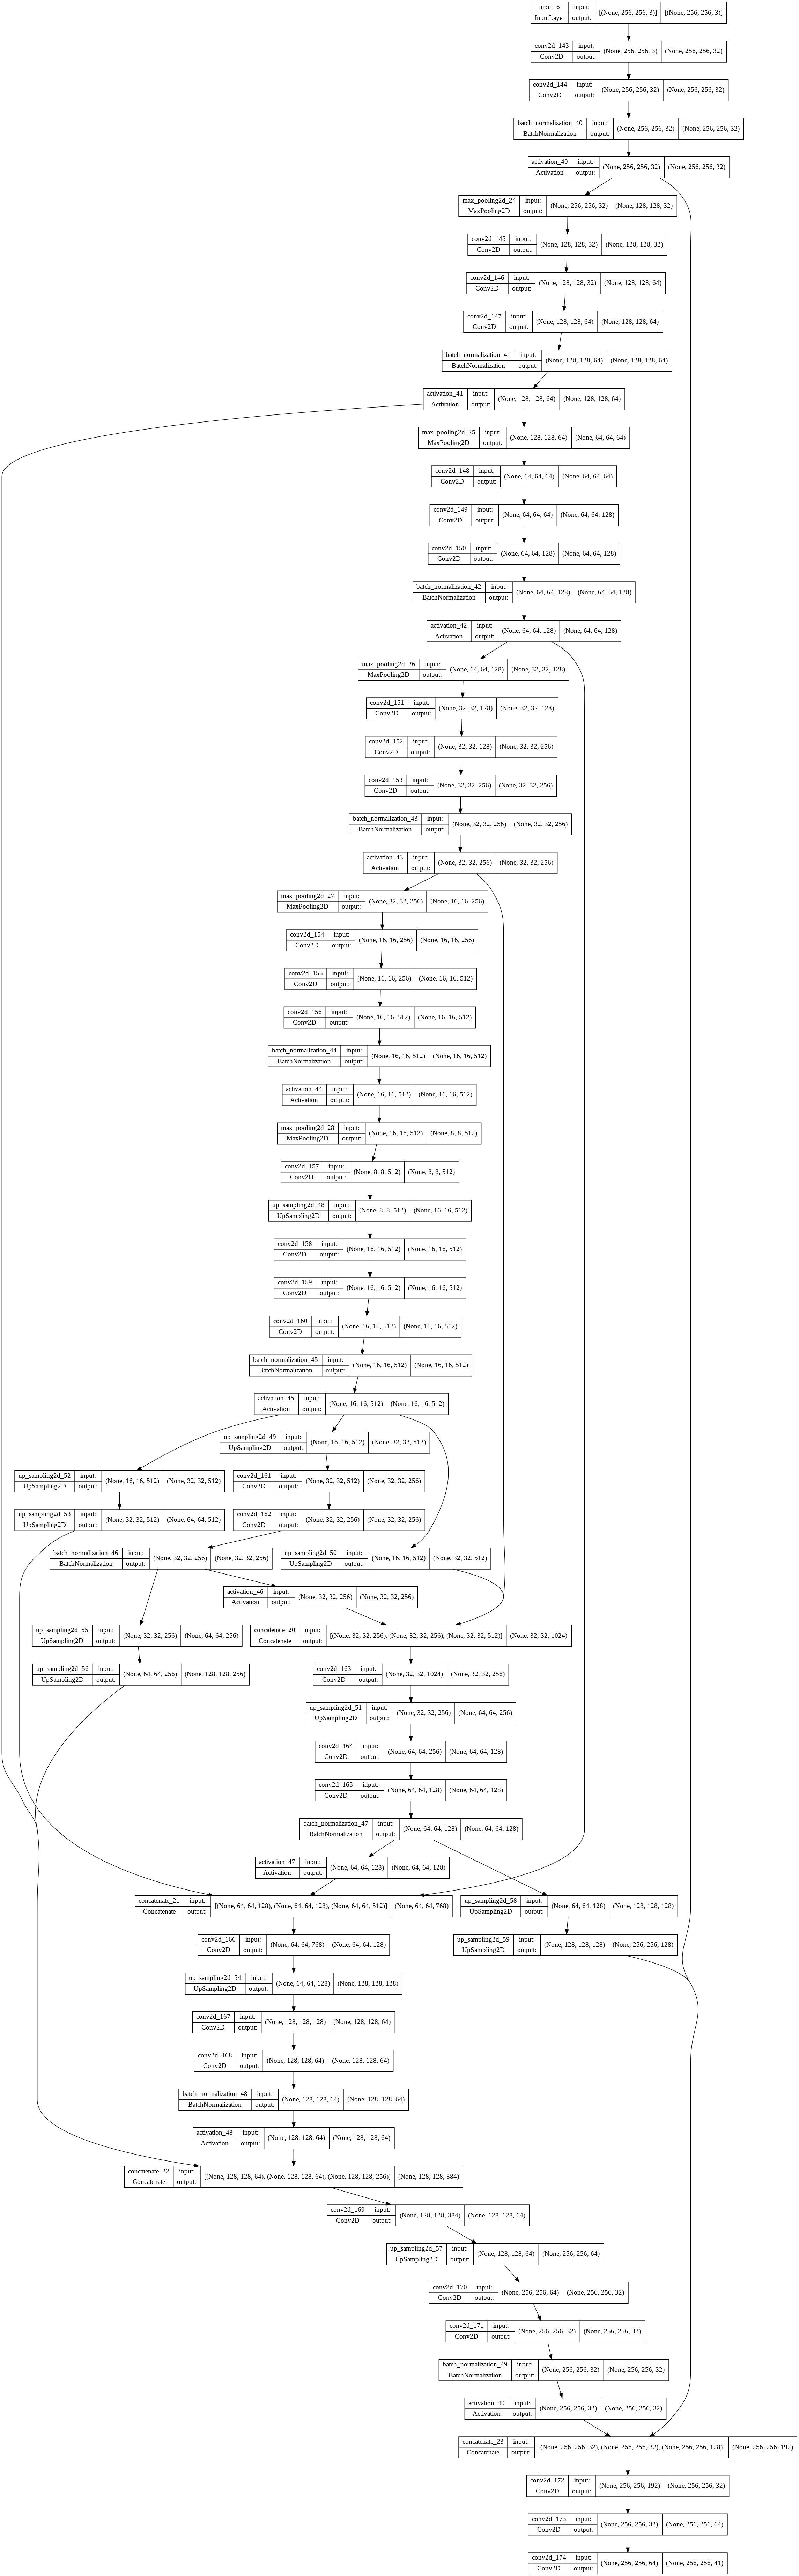

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='/content/drive/MyDrive/model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
!pip install segmentation_models
import segmentation_models as sm
import tensorflow as tf


IOU_score = sm.metrics.IOUScore(threshold=0.5)


weights = [0.024,0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024, 0.024]
print(len(weights))
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
41


### ***Training of UNET Model on Pavia hyperspectral Images***

**Model Compilation and Getting images data ready**

In [ ]:
scaler = MinMaxScaler()
#Update batch size to vary image batches

batch_size = 1

validation_batch_size = 1

training_npz_folder_path = '/content/drive/MyDrive/pavia_Hyperspectral_images/'

training_npz_files_list = os.listdir(training_npz_folder_path)[4:5]

training_npz_files_list = ['salinas31.npz']


validation_npz_folder_path = '/content/drive/MyDrive/pavia_Hyperspectral_images/'

validation_npz_files_list = os.listdir(validation_npz_folder_path)[4:5]

validation_npz_files_list = ['salinas31.npz']

print(validation_npz_files_list)




train_images_dataGenerator = imageLoader(img_dir=training_npz_folder_path,img_list=training_npz_files_list,batch_size=batch_size)


validation_images_dataGenerator = imageLoader(img_dir=validation_npz_folder_path,img_list=validation_npz_files_list,batch_size=validation_batch_size)


X, Y = train_images_dataGenerator.__next__()

print(X.shape)
print(Y.shape)

print()

steps_per_epoch = len(training_npz_files_list)//batch_size
val_steps_per_epoch = len(validation_npz_files_list)//batch_size

print(steps_per_epoch)

#model = multi_unet_model(n_classes=41,IMG_HEIGHT=256,IMG_WIDTH=256,IMG_CHANNELS=3)

#model = aspn(img_rows=256, img_cols=256, num_PC=150, nb_classes=41)

model = custom_segnet(n_classes=41, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

#model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

model.compile(optimizer=optimizer, loss=total_loss, metrics=['accuracy', IOU_score])

print(model.summary())

print(model.input_shape)
print(model.output_shape)

print("----------")
print(Y.shape)
print("----------")


# Hyperspectral image NORMALIZATION using MinMax scaler
# Comment these lines after normalizing whole IP and Pavia dataset images
New_X = []
for sample in X:

  ######################################### copy this function for noralization #########################################

  sample=scaler.fit_transform(sample.reshape(-1, sample.shape[-1])).reshape(sample.shape)

  New_X.append(sample)

  pass

X = np.array(New_X)

print(X.shape)

print()
#print(X[0,:,:,:])

['salinas31.npz']
(1, 256, 256, 3)
(1, 256, 256, 41)

1
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_300 (Conv2D)            (None, 256, 256, 32  896         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_301 (Conv2D)            (None, 256, 256, 32  9248        ['conv2d_300[0][0]']             
                                )  

In [ ]:
#dont run without normalization

history=model.fit(train_images_dataGenerator,
          steps_per_epoch=steps_per_epoch,
          validation_data=validation_images_dataGenerator,
          validation_steps=val_steps_per_epoch,
          epochs=500,
          verbose=1,
          )

model.save('/content/drive/MyDrive/pavia_unet.hdf5')

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 1.0233 - accuracy: 0.0175 - iou_score: 0.4634 - val_loss: 1.0793 - val_accuracy: 0.0551 - val_iou_score: 0.5623
Epoch 2/500
1/1 [==============================] - 0s 177ms/step - loss: 1.0148 - accuracy: 0.4088 - iou_score: 0.5174 - val_loss: 1.0799 - val_accuracy: 0.0551 - val_iou_score: 0.5379
Epoch 3/500
1/1 [==============================] - 0s 170ms/step - loss: 1.0121 - accuracy: 0.4676 - iou_score: 0.5524 - val_loss: 1.0385 - val_accuracy: 0.4856 - val_iou_score: 0.4997
Epoch 4/500
1/1 [==============================] - 0s 156ms/step - loss: 1.0103 - accuracy: 0.4888 - iou_score: 0.5255 - val_loss: 1.0359 - val_accuracy: 0.4882 - val_iou_score: 0.5973
Epoch 5/500
1/1 [==============================] - 0s 161ms/step - loss: 1.0119 - accuracy: 0.4413 - iou_score: 0.5542 - val_loss: 1.0359 - val_accuracy: 0.4882 - val_iou_score: 0.5973
Epoch 6/500
1/1 [==============================] - 0s 156ms/step - loss: 1.009

**Loss and accuracy graphs**

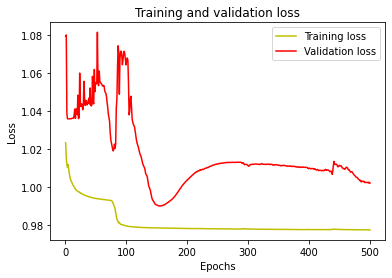

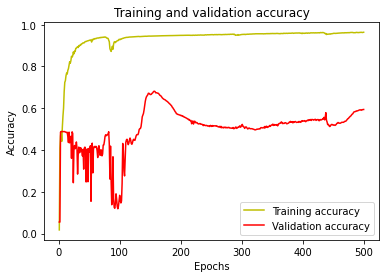

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

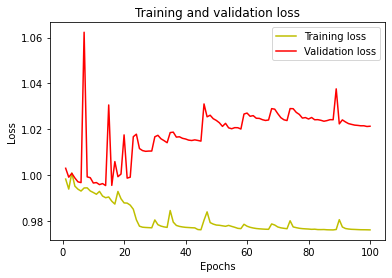

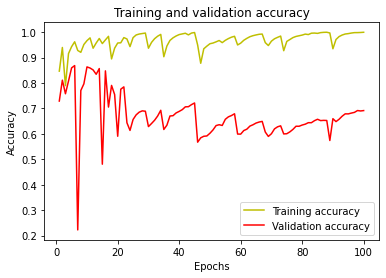

In [6]:
import pandas as pd

file_path = '/content/drive/MyDrive/pavia_Hyperspectral_images/alldata_custom_decodersegnet (1).csv'

dataFrame = pd.read_csv(file_path)





loss = np.array(dataFrame['loss'])
val_loss = np.array(dataFrame['val_loss'])
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = np.array(dataFrame['accuracy'])
val_acc = np.array(dataFrame['val_accuracy'])

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**plotting predction**


(256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 41)
(256, 256)
-----
(256, 256, 41)


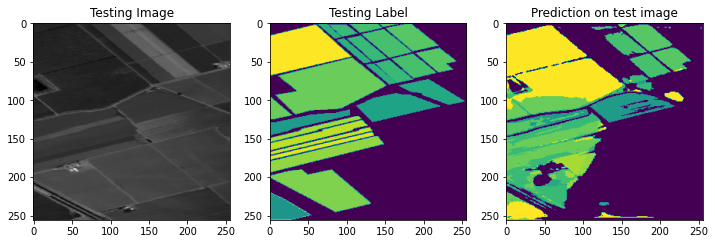

[ 0 16 17 18 19 20 21 22 23 24 25 26 27 29 30 31]


In [ ]:
#################################################
from keras.models import load_model

#my_model = load_model('/content/drive/MyDrive/pavia_unet.hdf5', custom_objects={"SpatialAttention":SpatialAttention,"SecondOrderPooling":SecondOrderPooling})

my_model = load_model('/content/drive/MyDrive/pavia_unet.hdf5',custom_objects={"dice_loss_plus_1focal_loss":total_loss,"iou_score":IOU_score})

#my_model = model

print(my_model)

print()

"""npz_files_folder_path = '/content/drive/MyDrive/pavia_Hyperspectral_images/'

file_name_list = os.listdir(npz_files_folder_path)

X, Y = load_img(img_dir=npz_files_folder_path,img_list=file_name_list)"""

query_hyperspectral_image = X[0]

print(query_hyperspectral_image.shape)

test_img_input = np.expand_dims(query_hyperspectral_image, axis=0)

print(test_img_input.shape)

#Prediction of UNET model

test_prediction = my_model.predict(test_img_input)

print(test_prediction.shape)

#converting prediction to normal from to categorial i.e   (256 x 256 x 10) ==> (256 x 256 x 1)

test_prediction_argmax=np.argmax(test_prediction, axis=3)[0,:,:]

print(test_prediction_argmax.shape)

prediction = test_prediction_argmax


ground_truth = Y[0]


print("-----")

#ground_truth = np.expand_dims(ground_truth, axis=2)

print(ground_truth.shape)


ground_truth=np.argmax(ground_truth, axis=2)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(query_hyperspectral_image[:,:,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction[:,:])
plt.show()

print(np.unique(prediction))